# Library

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import scipy.stats as stats
import umap.umap_ as umap

from scipy.stats import f_oneway, zscore, kruskal, chi2_contingency, entropy
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from wordcloud import WordCloud

# 20
from sklearn.tree import DecisionTreeClassifier
# 21 
from scipy.cluster.hierarchy import linkage, dendrogram
# 23
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# 25
from math import pi
# 27
import itertools

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


# Load data

In [38]:
df = pd.read_csv('../data/raw/data_capstone.csv')

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# EDA

## 1. MISSING VALUE Heatmap

In [39]:
def eda_missing_full(df):
    print("===== EDA MISSING VALUES & DUPLICATION CHECK =====\n")
    
    print(">>> Ringkasan Missing Values per Kolom:\n")
    print(df.isnull().sum(), "\n")

    print(f"Total Missing Values: {df.isnull().sum().sum()}\n")

    print(">>> Plot 1: Missing Values Heatmap (Seaborn)\n")
    plt.figure(figsize=(12, 5))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title("Missing Values Heatmap (Seaborn)")
    plt.show()

    print(">>> Plot 2: Missing Value Matrix (missingno)\n")
    msno.matrix(df)
    plt.title("Missing Value Matrix")
    plt.show()

    print(">>> Plot 3: Missing Value Count per Feature (missingno)\n")
    msno.bar(df)
    plt.title("Missing Value Count per Feature")
    plt.show()

    print(">>> Plot 4: Missing Value Correlation Heatmap (missingno)\n")
    try:
        msno.heatmap(df)
        plt.title("Missing Value Correlation Heatmap")
        plt.show()
    except:
        print("Missingno heatmap tidak dapat dihitung.")

In [40]:
# Duplicate check
print("\n>>> Mengecek duplikasi baris...\n")
dupe_mask = df.duplicated(keep=False)
dupes = df[dupe_mask]

if dupes.empty:
    print("Tidak ada baris duplikat.\n")
else:
    print(f"Ditemukan {dupes.shape[0]} baris duplikat.\n")
    print(">>> Plot 5: Duplicate Row Heatmap\n")

    plt.figure(figsize=(14, 4))
    sns.heatmap(dupes.isnull(), cbar=False, cmap="Reds")
    plt.title("Duplicate Row Heatmap (Only on Duplicate Rows)")
    plt.show()


>>> Mengecek duplikasi baris...

Tidak ada baris duplikat.



===== EDA MISSING VALUES & DUPLICATION CHECK =====

>>> Ringkasan Missing Values per Kolom:

customer_id          0
plan_type            0
device_brand         0
avg_data_usage_gb    0
pct_video_usage      0
avg_call_duration    0
sms_freq             0
monthly_spend        0
topup_freq           0
travel_score         0
complaint_count      0
target_offer         0
dtype: int64 

Total Missing Values: 0

>>> Plot 1: Missing Values Heatmap (Seaborn)



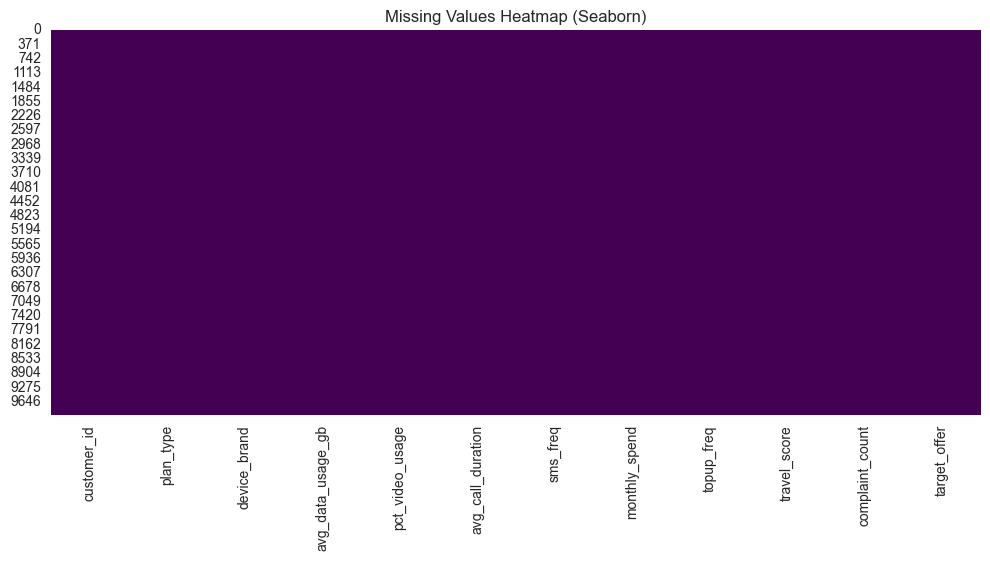

>>> Plot 2: Missing Value Matrix (missingno)



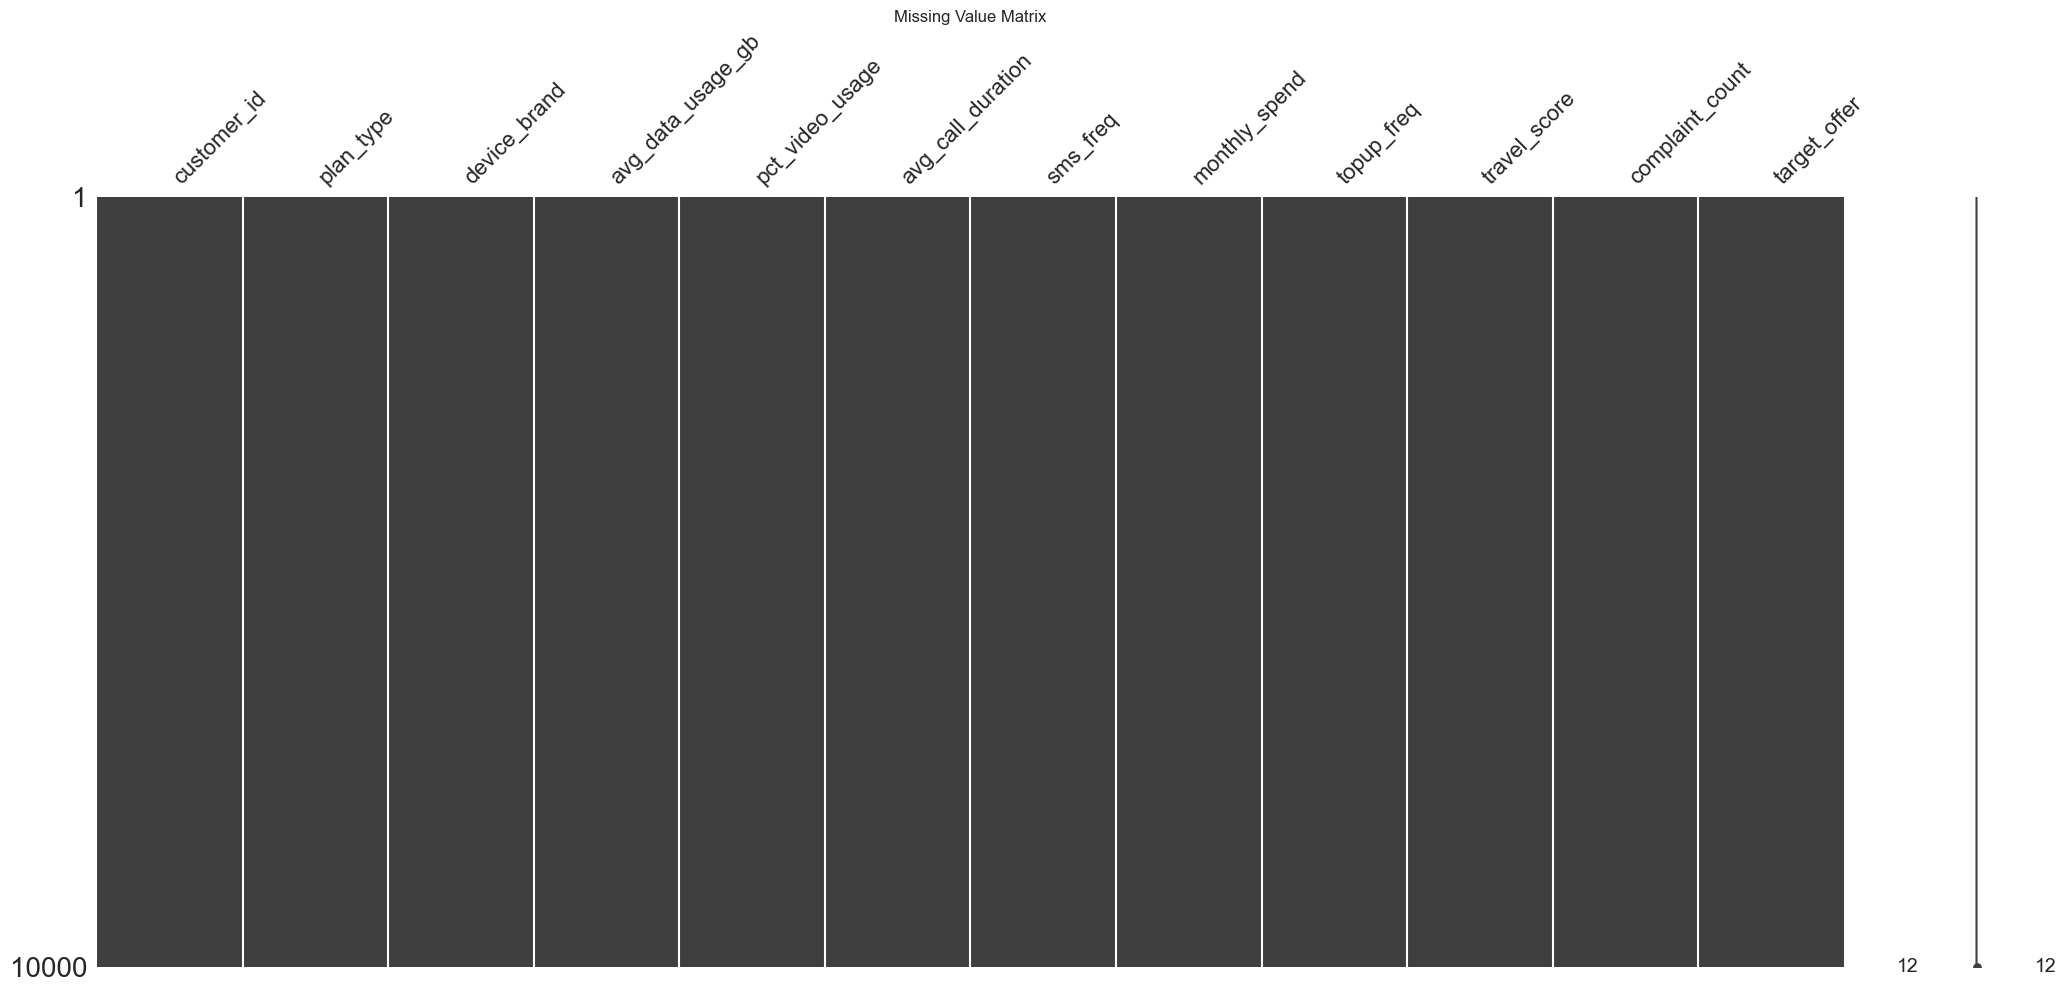

>>> Plot 3: Missing Value Count per Feature (missingno)



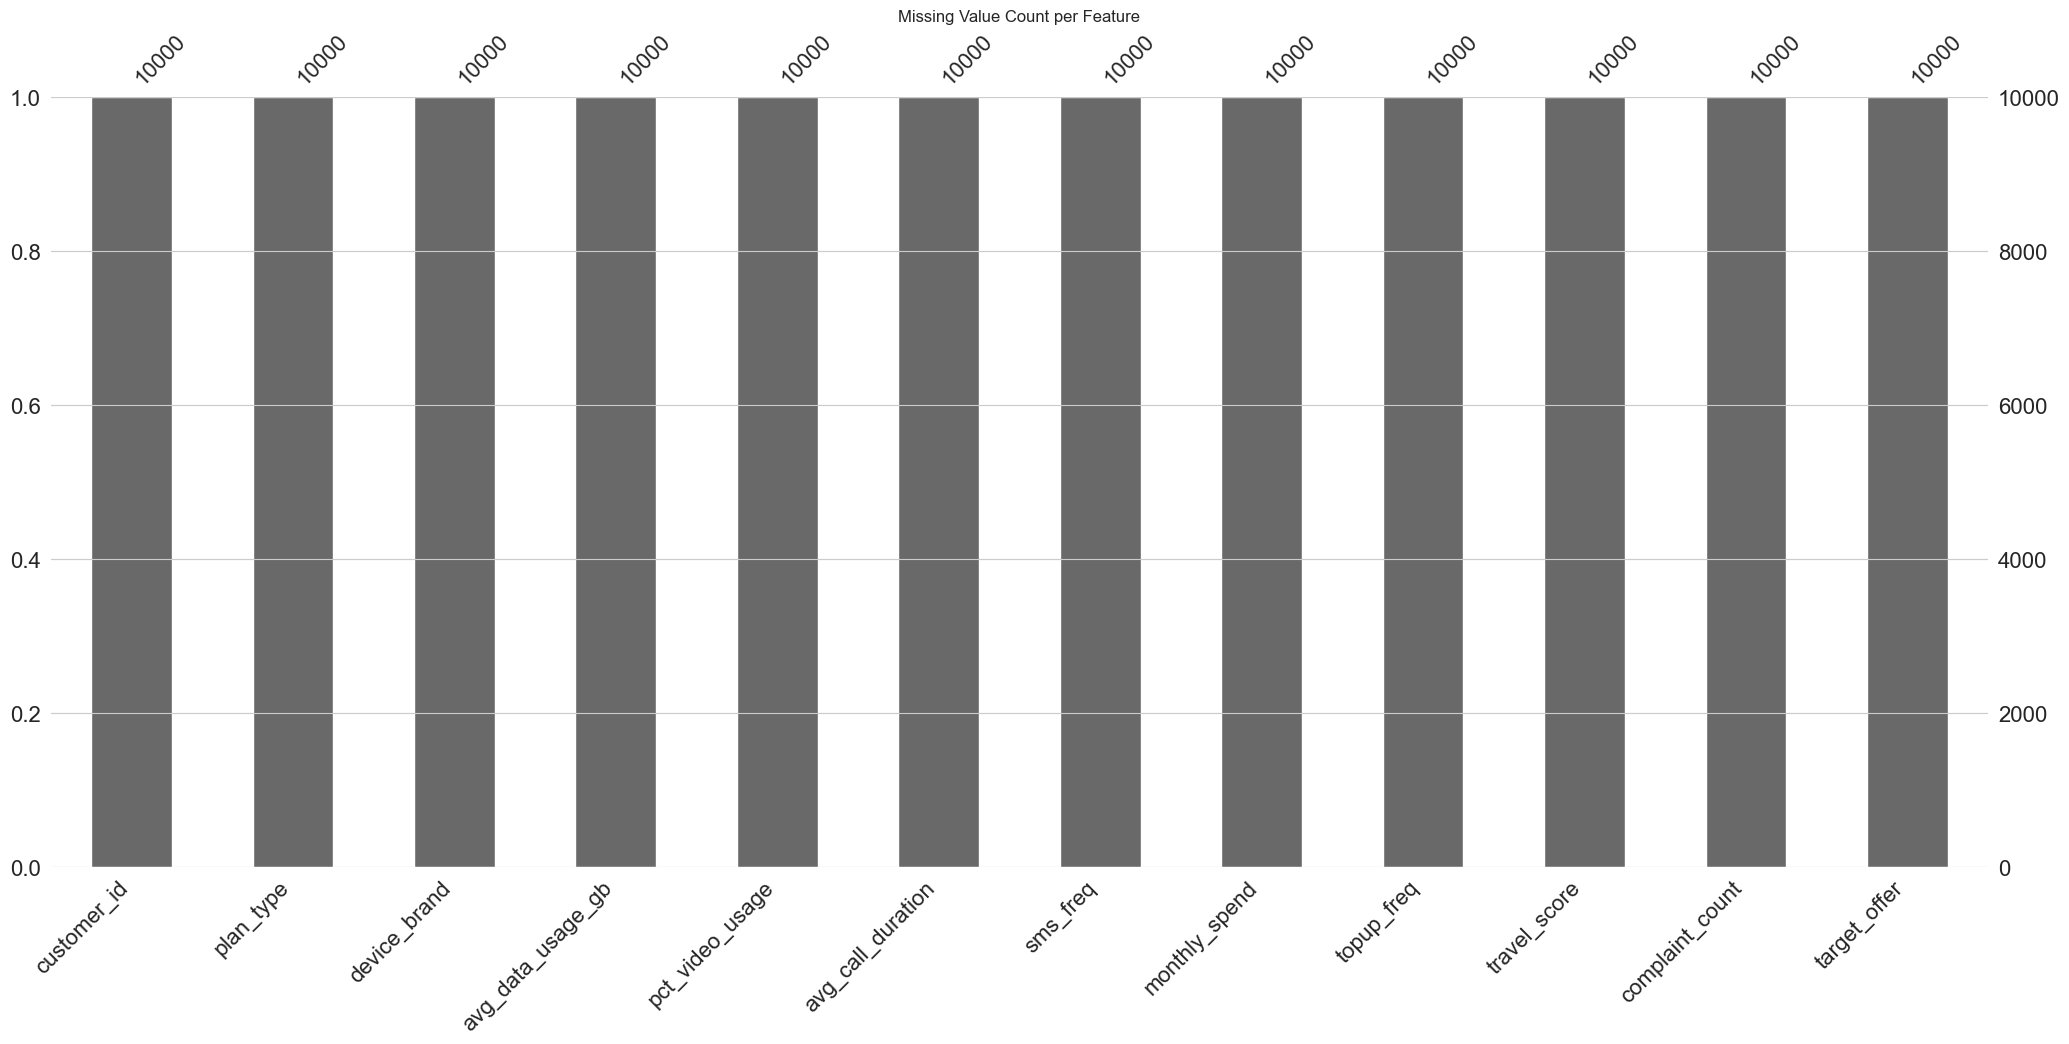

>>> Plot 4: Missing Value Correlation Heatmap (missingno)



c:\Users\Asus\Documents\ASAH 2025\CAPSTONE\.venv\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
c:\Users\Asus\Documents\ASAH 2025\CAPSTONE\.venv\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


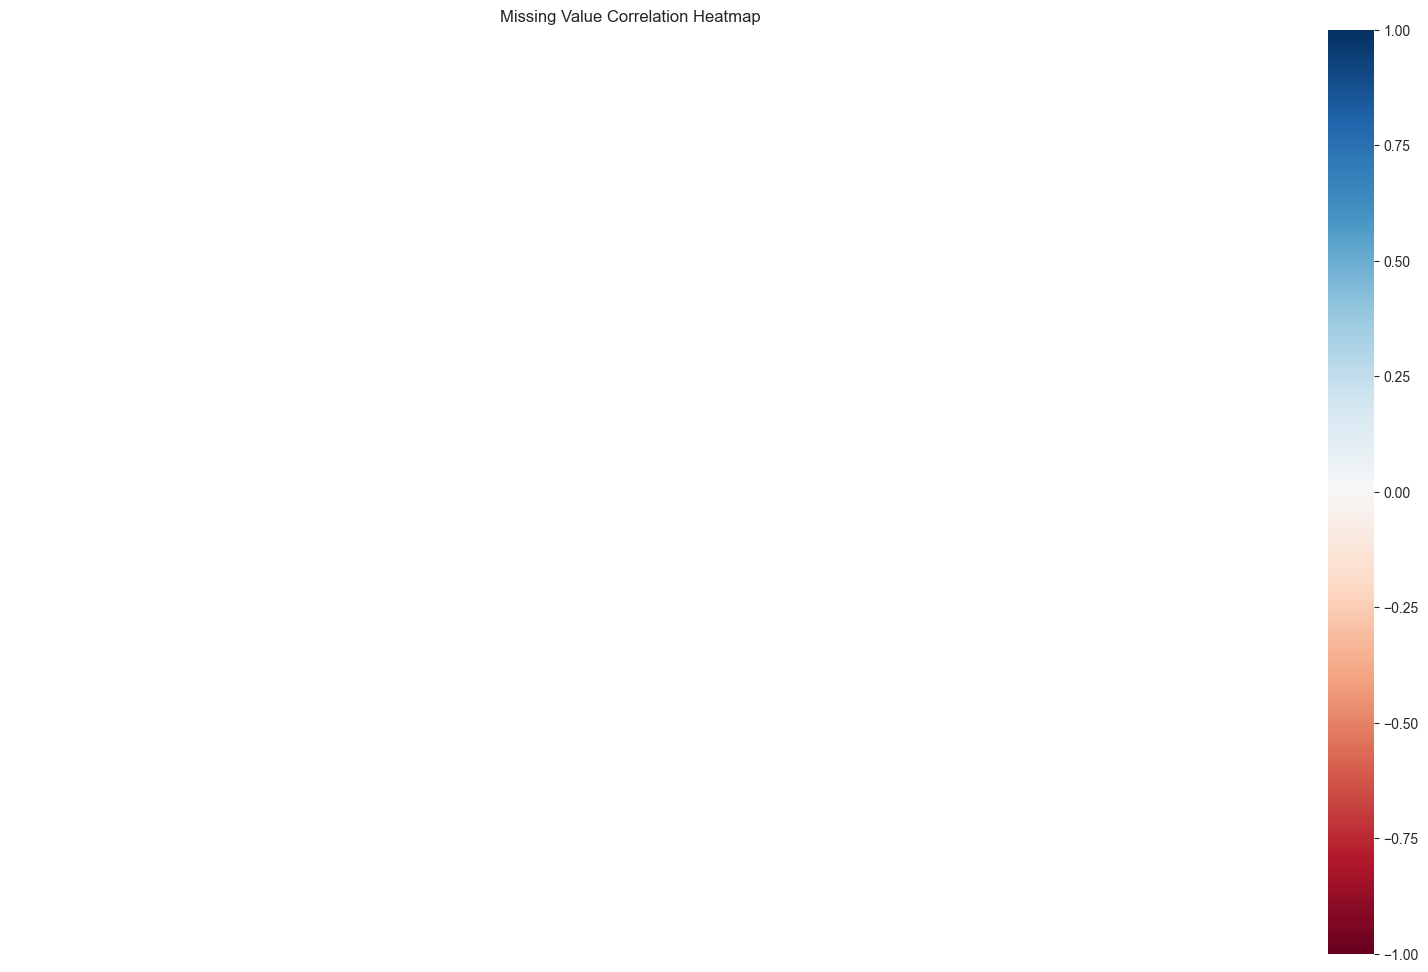

In [41]:
eda_missing_full(df)

## 2. DISTRIBUSI NUMERIK

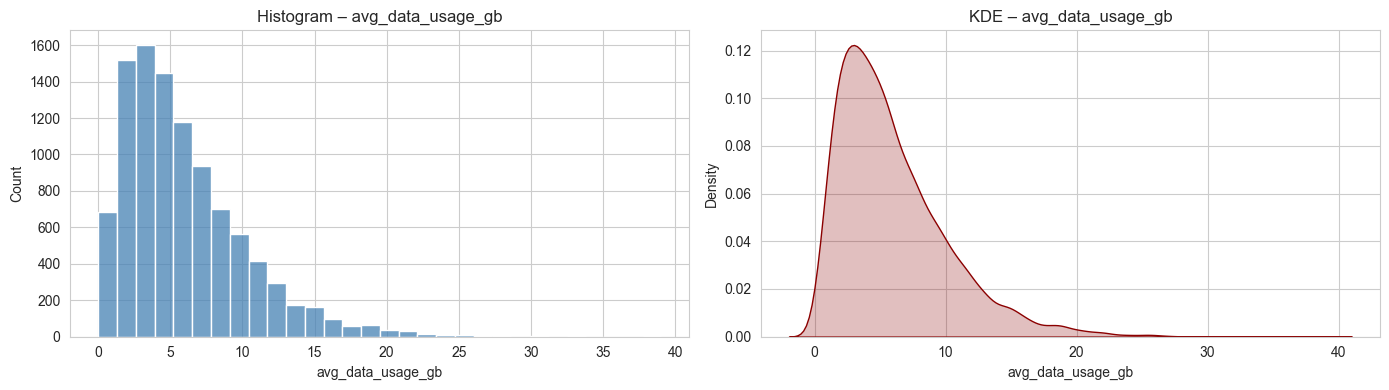

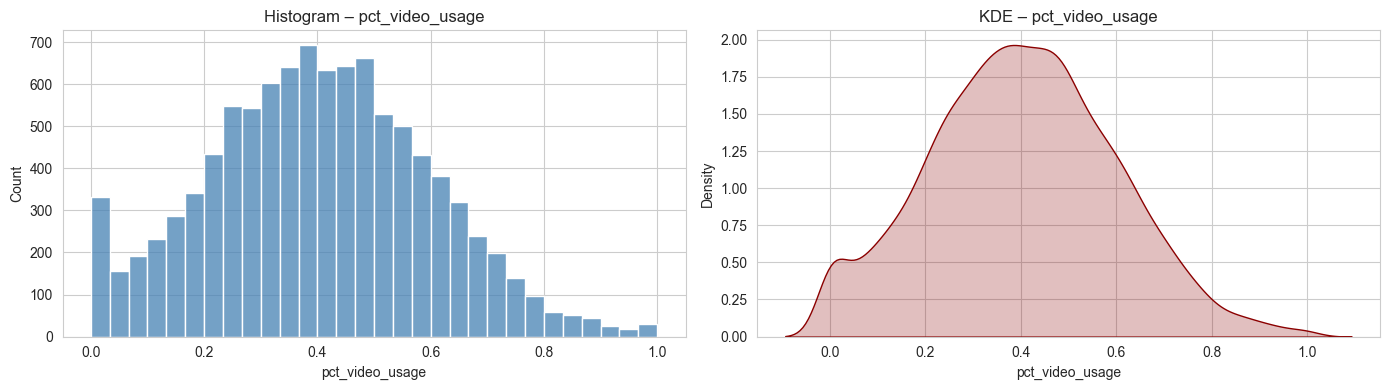

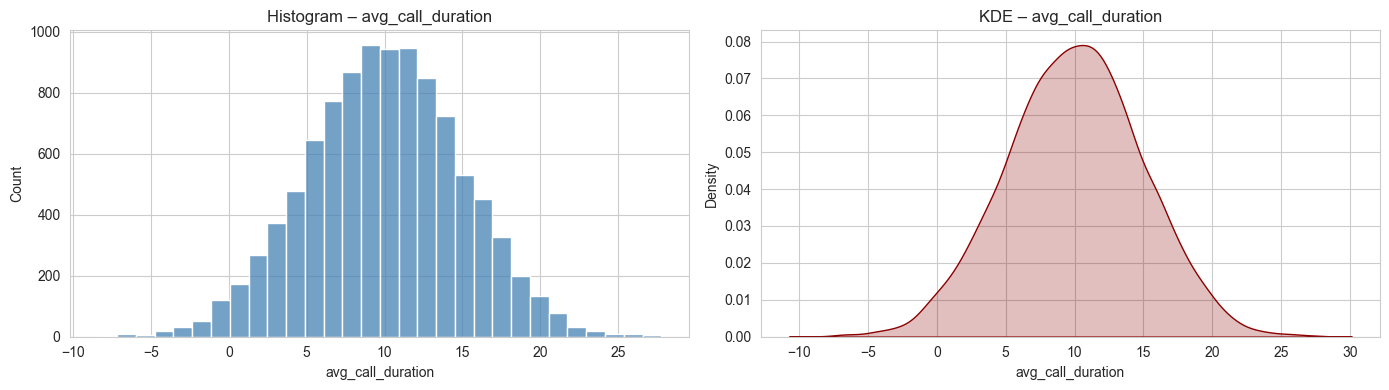

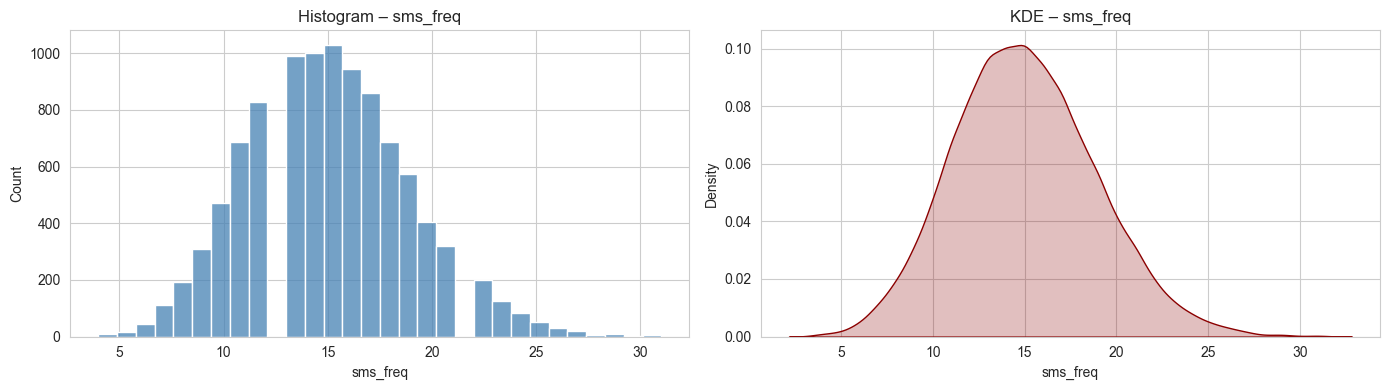

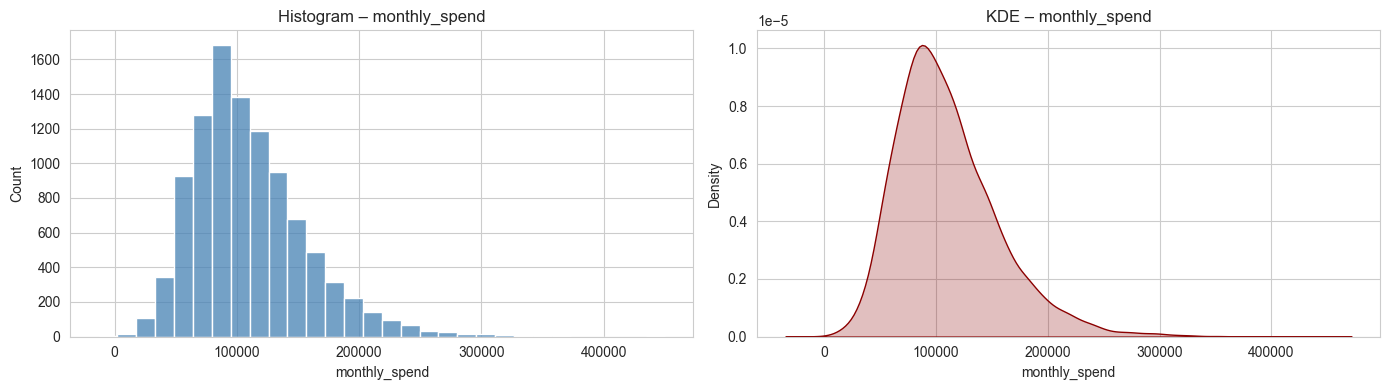

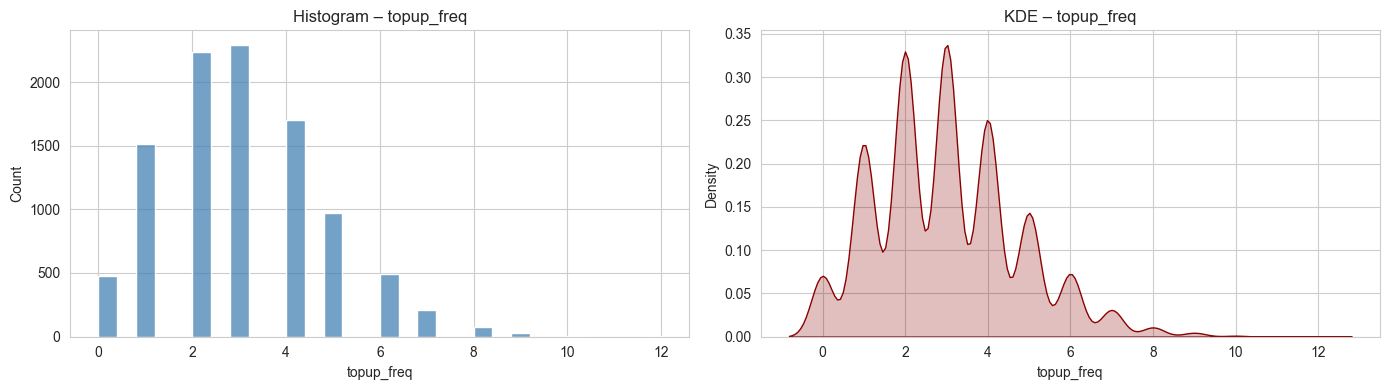

In [42]:
def plot_numeric_distributions(df, numeric_cols):
    for col in numeric_cols:
        fig, ax = plt.subplots(1, 2, figsize=(14, 4))

        sns.histplot(df[col], kde=False, ax=ax[0], color="steelblue", bins=30)
        ax[0].set_title(f"Histogram – {col}")

        sns.kdeplot(df[col], fill=True, ax=ax[1], color="darkred")
        ax[1].set_title(f"KDE – {col}")

        plt.tight_layout()
        plt.show()

plot_numeric_distributions(df, numeric_cols[:6])

## 3. DISTRIBUSI KATEGORIKAL

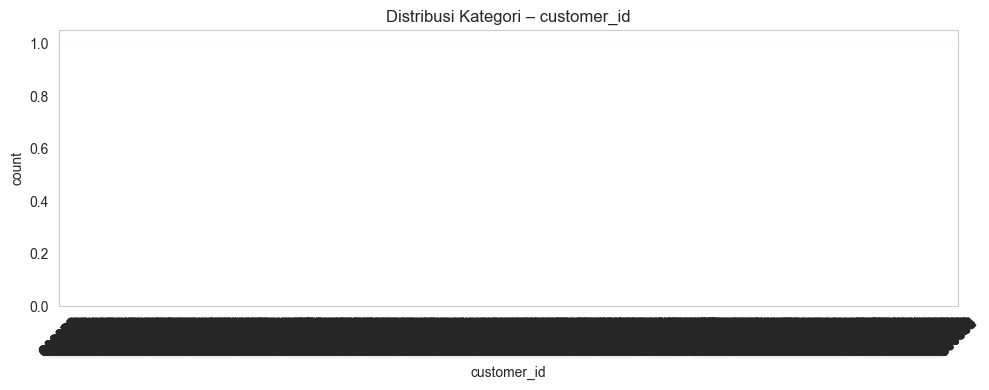

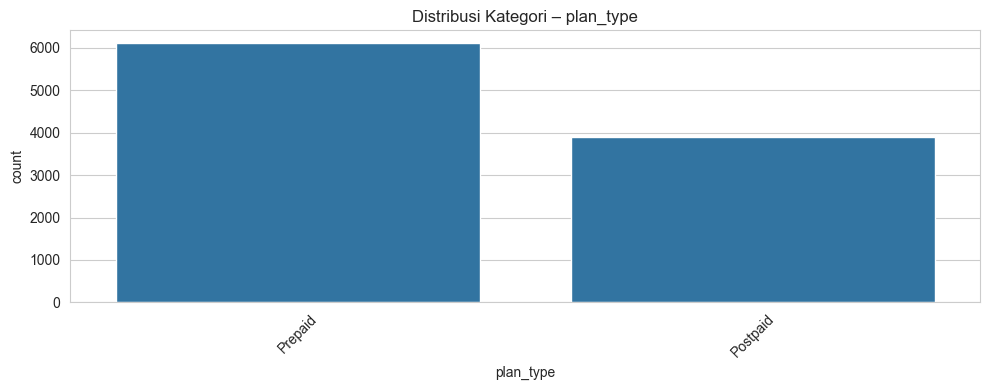

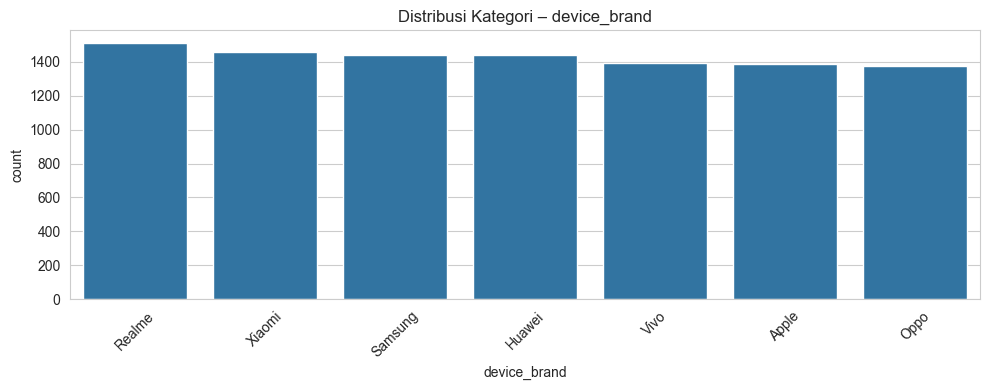

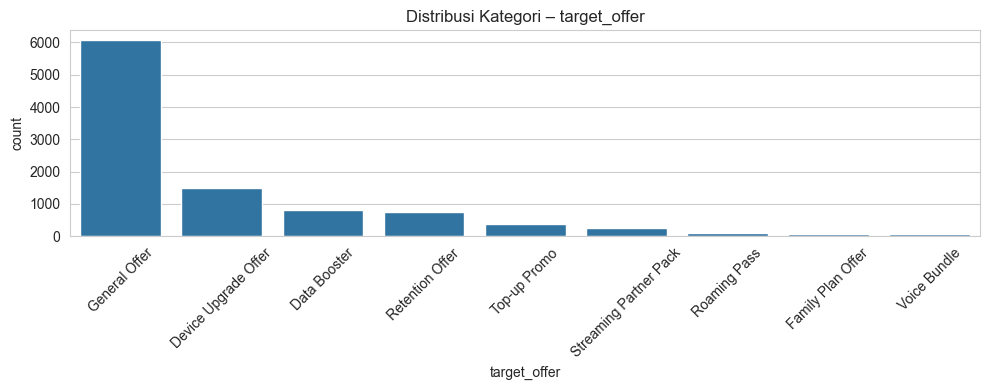

In [43]:
def plot_categorical(df, cat_cols):
    for col in cat_cols:
        plt.figure(figsize=(10, 4))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f"Distribusi Kategori – {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_categorical(df, cat_cols)


## 4. ANOVA SIGNIFICANCE TEST

In [44]:
def compute_anova(df, numeric_cols, target):
    results = {}
    for col in numeric_cols:
        groups = [group[col].dropna() for _, group in df.groupby(target)]
        try:
            _, p_val = f_oneway(*groups)
            results[col] = p_val
        except:
            results[col] = np.nan

    return pd.DataFrame.from_dict(results, orient='index', columns=['p_value']).sort_values("p_value")

anova_results = compute_anova(df, numeric_cols, 'target_offer')
print("\n=== Top Features Paling Signifikan (ANOVA) ===")
print(anova_results.head())



=== Top Features Paling Signifikan (ANOVA) ===
                         p_value
avg_data_usage_gb   0.000000e+00
pct_video_usage     0.000000e+00
monthly_spend       0.000000e+00
complaint_count     0.000000e+00
travel_score       1.460429e-181


## 5. PCA 2D

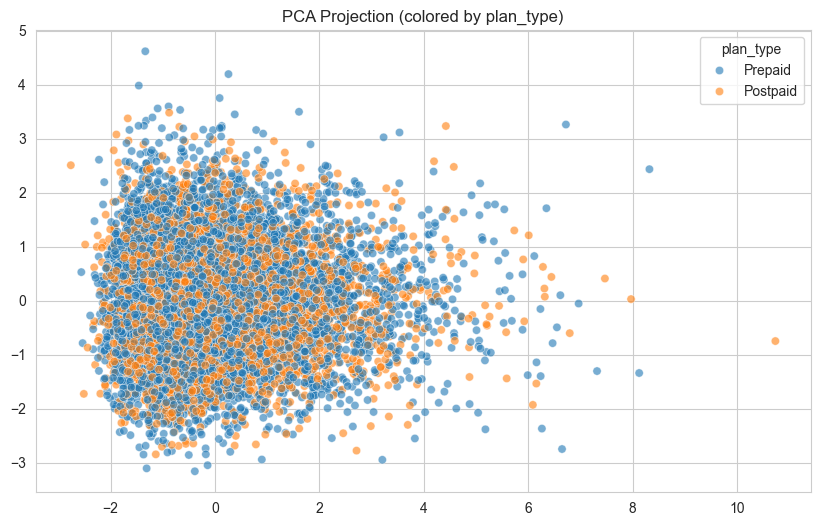

In [45]:
def pca_plot(df, numeric_cols, label_col):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df[numeric_cols])

    pcs = PCA(n_components=2).fit_transform(scaled)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=pcs[:, 0], y=pcs[:, 1], hue=df[label_col], alpha=0.6)
    plt.title(f"PCA Projection (colored by {label_col})")
    plt.show()

pca_plot(df, numeric_cols, 'plan_type')

## 6. MULTICOLLINEARITY (VIF)

In [46]:
def compute_vif(df, numeric_cols):
    vif_df = pd.DataFrame()
    vif_df["feature"] = numeric_cols
    vif_df["VIF"] = [
        variance_inflation_factor(df[numeric_cols].values, i)
        for i in range(len(numeric_cols))
    ]
    return vif_df.sort_values("VIF", ascending=False)

print("\n=== VIF (Multicollinearity Check) ===")
print(compute_vif(df, numeric_cols))


=== VIF (Multicollinearity Check) ===
             feature        VIF
4      monthly_spend  29.522502
0  avg_data_usage_gb  14.947755
3           sms_freq  10.151626
1    pct_video_usage   4.698680
2  avg_call_duration   4.526472
6       travel_score   3.858773
5         topup_freq   3.740263
7    complaint_count   1.469061


## 7. OUTLIER DETECTION

In [47]:
def detect_outliers(df, numeric_cols):
    return pd.Series({
        col: (np.abs(zscore(df[col].dropna())) > 3).sum()
        for col in numeric_cols
    }).sort_values(ascending=False)

print("\n=== Jumlah Outlier (Z-score > 3) ===")
print(detect_outliers(df, numeric_cols))



=== Jumlah Outlier (Z-score > 3) ===
avg_data_usage_gb    151
complaint_count      138
monthly_spend        108
topup_freq            38
travel_score          38
sms_freq              35
avg_call_duration     31
pct_video_usage       18
dtype: int64


## 8. SEGMENTASI

C:\Users\Asus\AppData\Local\Temp\ipykernel_11852\3158303065.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='spend_segment', palette='viridis')


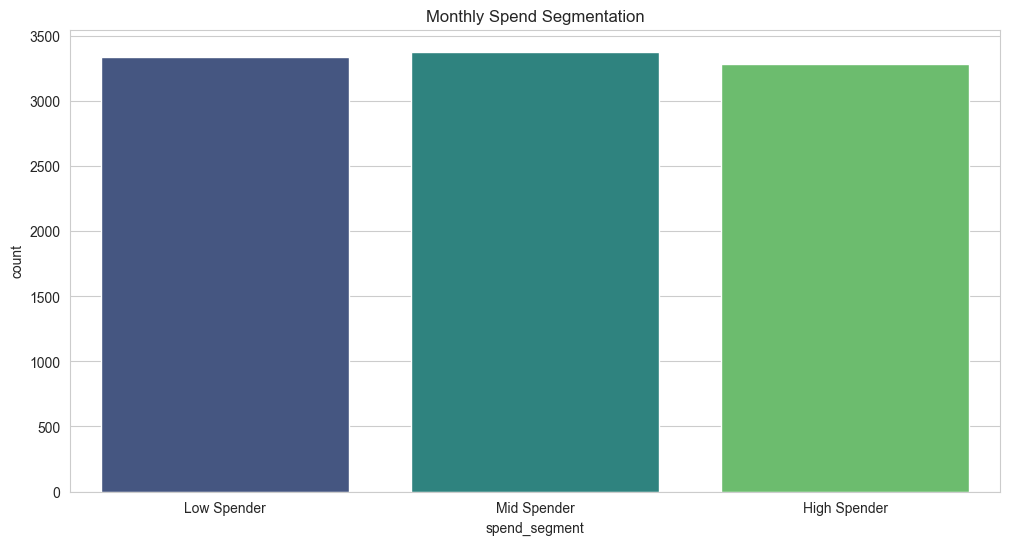

In [48]:
df['spend_segment'] = pd.qcut(
    df['monthly_spend'], q=3,
    labels=['Low Spender', 'Mid Spender', 'High Spender']
)

sns.countplot(data=df, x='spend_segment', palette='viridis')
plt.title("Monthly Spend Segmentation")
plt.show()

## 9. WORDCLOUD

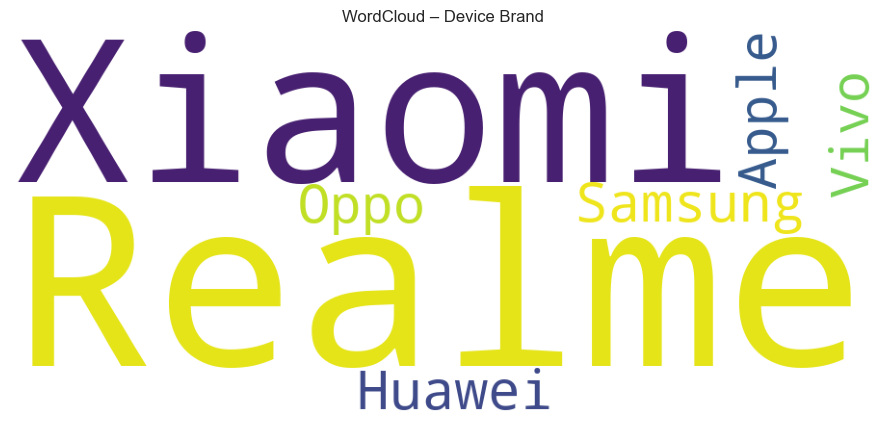

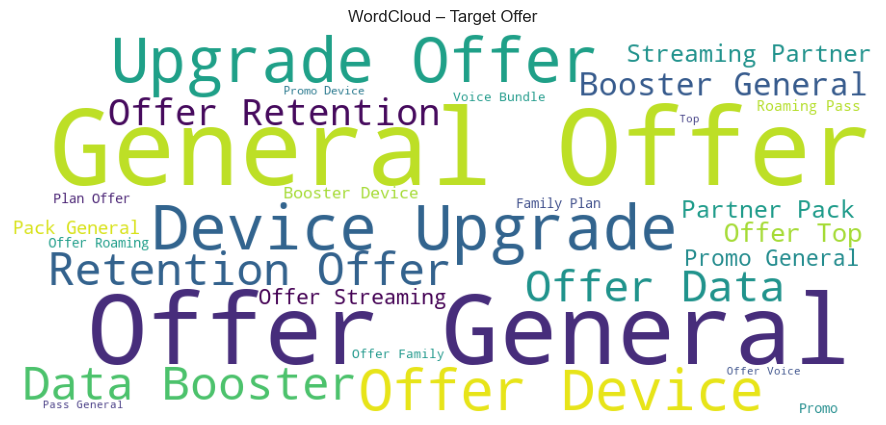

In [49]:
def plot_wordcloud(text, title):
    wc = WordCloud(width=900, height=400, background_color='white').generate(text)
    plt.figure(figsize=(12, 5))
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wordcloud(" ".join(df['device_brand'].astype(str)), "WordCloud – Device Brand")
plot_wordcloud(" ".join(df['target_offer'].astype(str)), "WordCloud – Target Offer")


## 10. PAIRPLOT INTERAKSI

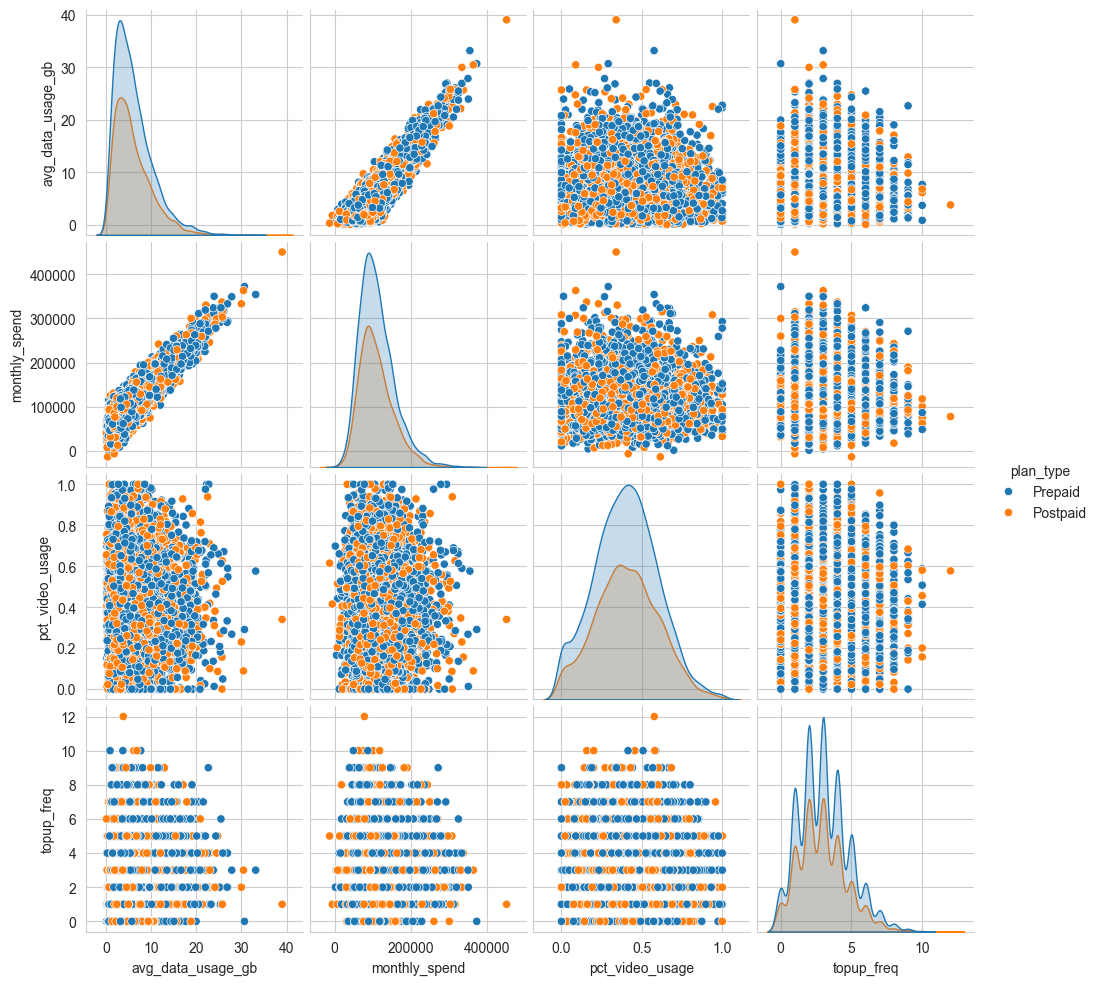

In [50]:
interaction_cols = ['avg_data_usage_gb', 'monthly_spend', 'pct_video_usage', 'topup_freq']

sns.pairplot(df[interaction_cols + ['plan_type']], hue='plan_type', diag_kind='kde')
plt.show()

## 11. MUTUAL INFORMATION


=== TOP 15 MUTUAL INFORMATION FEATURES ===
              feature  mutual_info
6       monthly_spend     0.428309
10      spend_segment     0.306463
2   avg_data_usage_gb     0.305929
9     complaint_count     0.180141
3     pct_video_usage     0.169857
1        device_brand     0.099124
8        travel_score     0.053295
4   avg_call_duration     0.033887
0           plan_type     0.032942
7          topup_freq     0.025330
5            sms_freq     0.009105


C:\Users\Asus\AppData\Local\Temp\ipykernel_11852\1526218402.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mi_df.head(15), x='mutual_info', y='feature', palette="viridis")


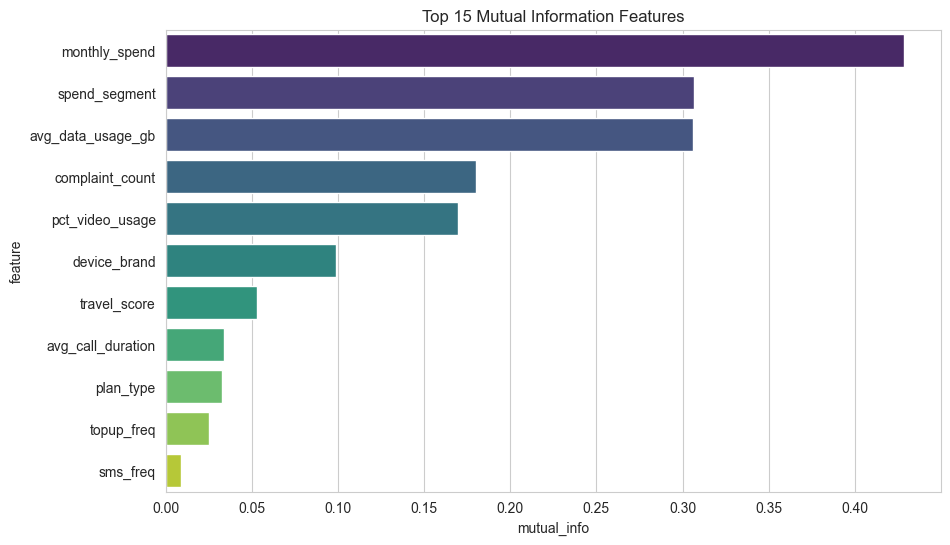

In [51]:
X = df.drop(columns=['target_offer', 'customer_id'])
y = df['target_offer']

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

enc = OrdinalEncoder()
X[cat_cols] = enc.fit_transform(X[cat_cols].astype(str))

mi_scores = mutual_info_classif(X, y, discrete_features=[X.columns.get_loc(c) for c in cat_cols])

mi_df = pd.DataFrame({"feature": X.columns, "mutual_info": mi_scores}).sort_values('mutual_info', ascending=False)

print("\n=== TOP 15 MUTUAL INFORMATION FEATURES ===")
print(mi_df.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(data=mi_df.head(15), x='mutual_info', y='feature', palette="viridis")
plt.title("Top 15 Mutual Information Features")
plt.show()


## 12. VARIANCE CHECK

C:\Users\Asus\AppData\Local\Temp\ipykernel_11852\552097368.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=variances.values, y=variances.index, palette="Blues_r")


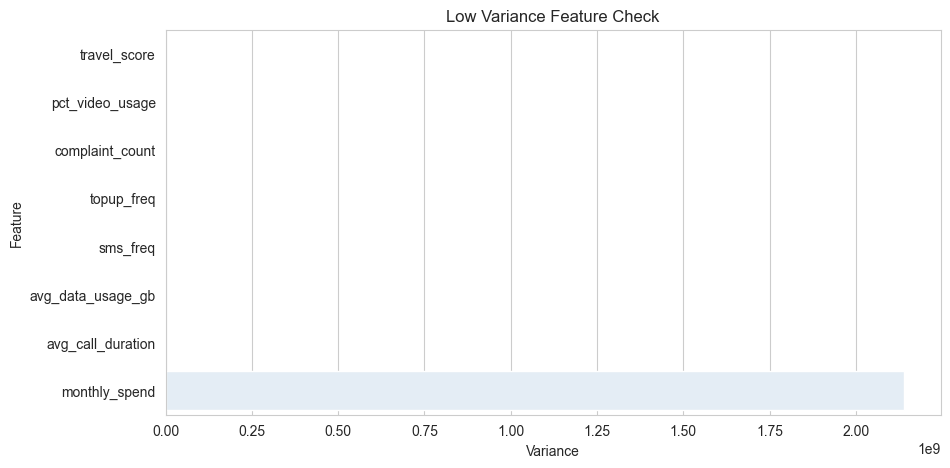

In [52]:
variances = df[num_cols].var().sort_values()

plt.figure(figsize=(10, 5))
sns.barplot(x=variances.values, y=variances.index, palette="Blues_r")
plt.title("Low Variance Feature Check")
plt.xlabel("Variance")
plt.ylabel("Feature")
plt.show()

## 13. SKEWNESS

C:\Users\Asus\AppData\Local\Temp\ipykernel_11852\1820429709.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=skew_vals.values, y=skew_vals.index, palette="coolwarm")


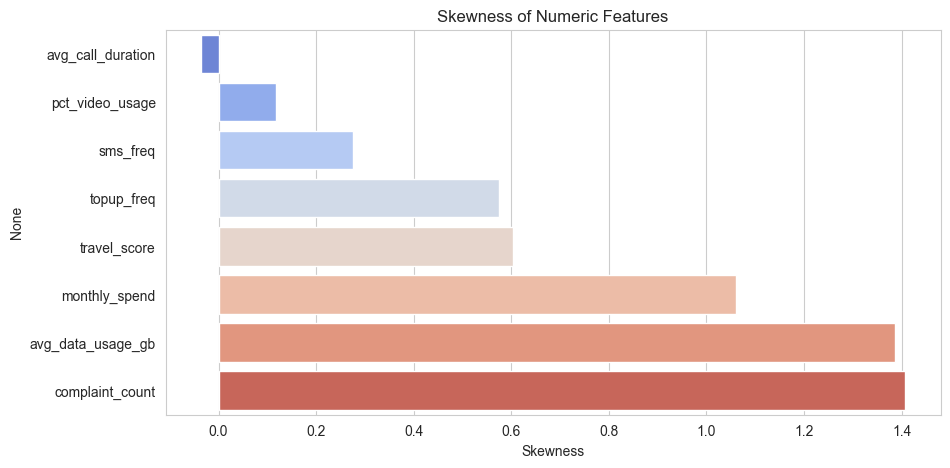

In [53]:
skew_vals = df[num_cols].skew().sort_values()

plt.figure(figsize=(10, 5))
sns.barplot(x=skew_vals.values, y=skew_vals.index, palette="coolwarm")
plt.title("Skewness of Numeric Features")
plt.xlabel("Skewness")
plt.show()

## 14. Q-Q PLOTS

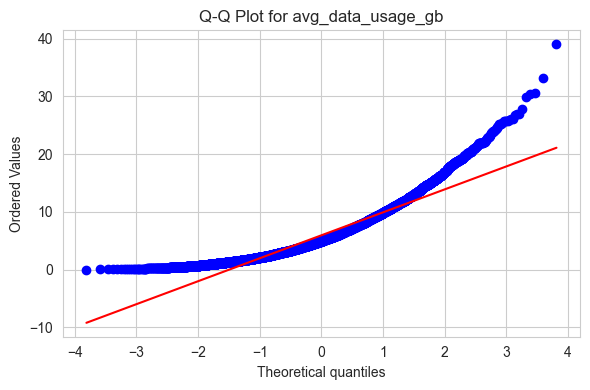

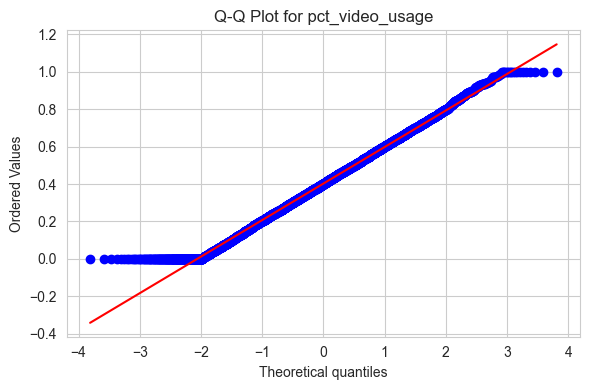

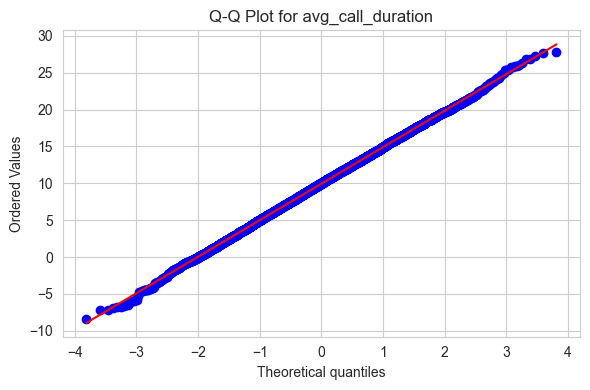

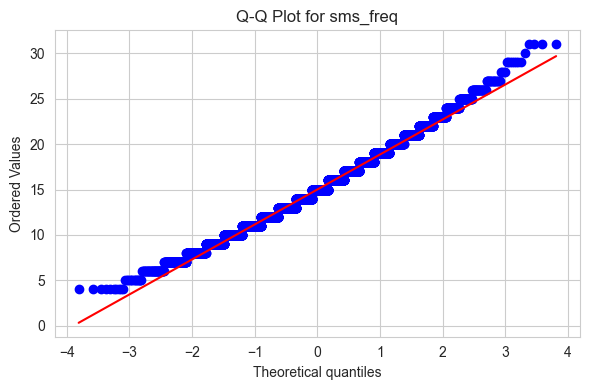

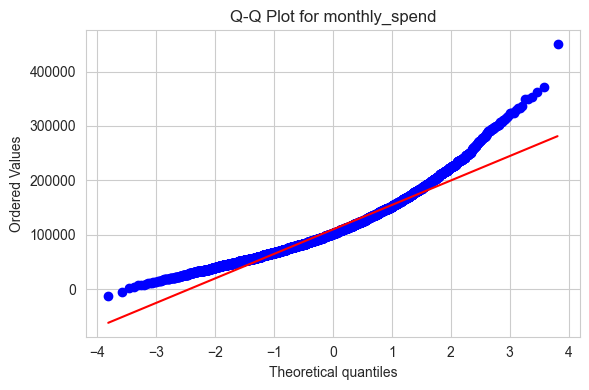

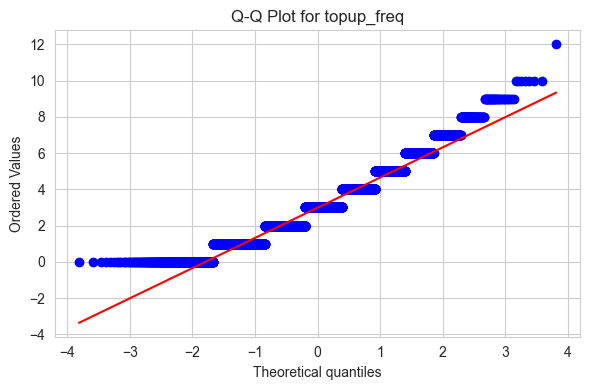

In [54]:
for col in num_cols[:6]:
    plt.figure(figsize=(6, 4))
    stats.probplot(df[col].dropna(), dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for {col}")
    plt.tight_layout()
    plt.show()

## 15. RANGE CHECK

In [55]:
range_check = pd.DataFrame({
    "min": df[num_cols].min(),
    "max": df[num_cols].max(),
    "median": df[num_cols].median()
})

print("=== RANGE CHECK (Out-of-bound values detection) ===")
print(range_check)

=== RANGE CHECK (Out-of-bound values detection) ===
                            min            max         median
avg_data_usage_gb      0.030000      39.020000       4.990000
pct_video_usage        0.000000       1.000000       0.400116
avg_call_duration     -8.370000      27.770000      10.020000
sms_freq               4.000000      31.000000      15.000000
monthly_spend     -13000.000000  450000.000000  102000.000000
topup_freq             0.000000      12.000000       3.000000
travel_score           0.003376       0.854814       0.261206
complaint_count        0.000000       5.000000       0.000000


## 16. LOGICAL CONSISTENCY CHECK

=== LOGICAL CONSISTENCY CHECK ===
                         count
monthly_spend_negative       2
avg_data_usage_negative      0
complaint_negative           0
topup_negative               0


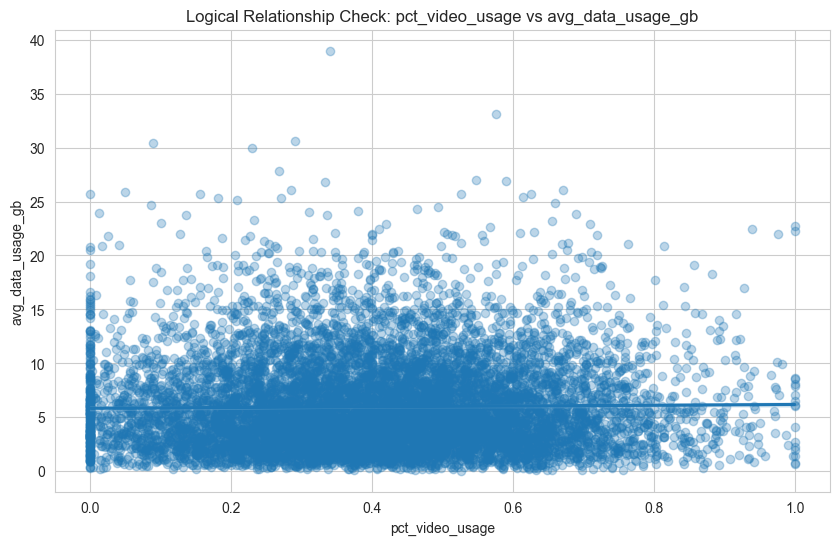

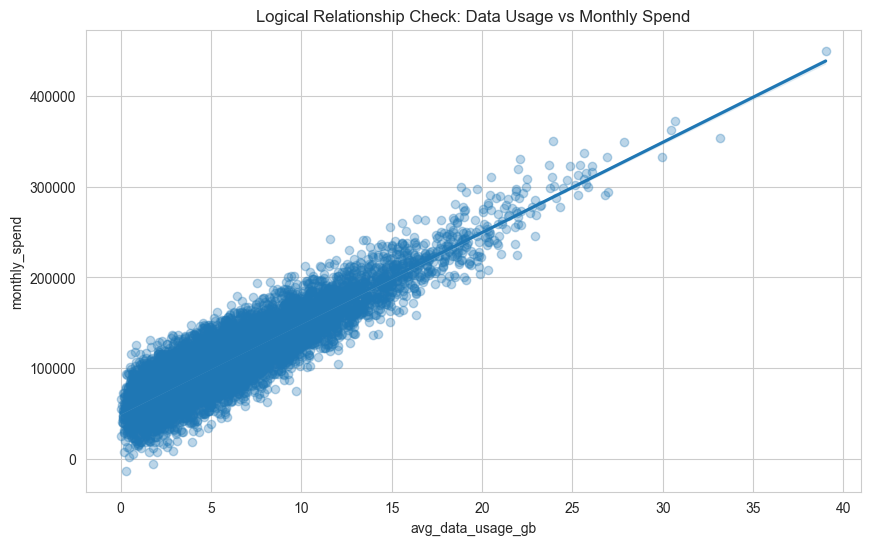

In [56]:
inconsistent = pd.DataFrame({
    "monthly_spend_negative": (df['monthly_spend'] < 0).sum(),
    "avg_data_usage_negative": (df['avg_data_usage_gb'] < 0).sum(),
    "complaint_negative": (df['complaint_count'] < 0).sum(),
    "topup_negative": (df['topup_freq'] < 0).sum()
}, index=["count"]).T

print("=== LOGICAL CONSISTENCY CHECK ===")
print(inconsistent)

plt.figure(figsize=(10, 6))
sns.regplot(x=df['pct_video_usage'], y=df['avg_data_usage_gb'], scatter_kws={"alpha":0.3})
plt.title("Logical Relationship Check: pct_video_usage vs avg_data_usage_gb")
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(x=df['avg_data_usage_gb'], y=df['monthly_spend'], scatter_kws={"alpha":0.3})
plt.title("Logical Relationship Check: Data Usage vs Monthly Spend")
plt.show()

## 17. CATEGORY CARDINALITY

C:\Users\Asus\AppData\Local\Temp\ipykernel_11852\1185480241.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_cardinality.values, y=cat_cardinality.index, palette="viridis")


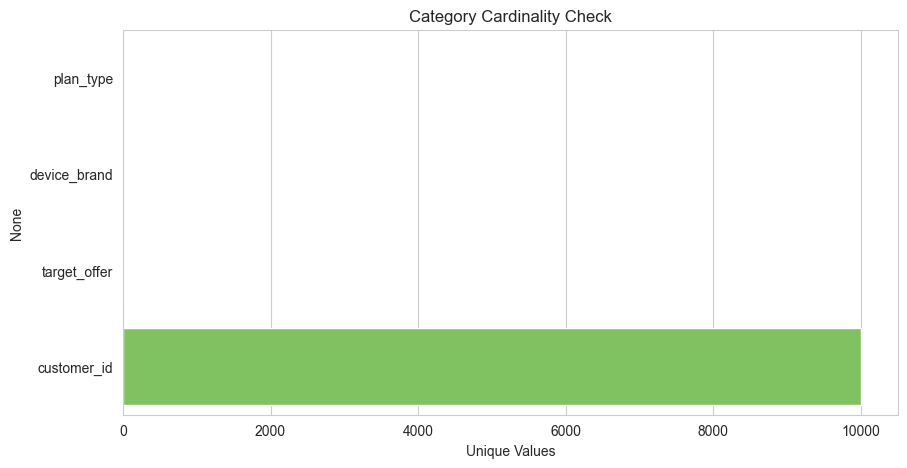

In [57]:
cat_cardinality = df.select_dtypes(include=['object']).nunique().sort_values()

plt.figure(figsize=(10, 5))
sns.barplot(x=cat_cardinality.values, y=cat_cardinality.index, palette="viridis")
plt.title("Category Cardinality Check")
plt.xlabel("Unique Values")
plt.show()

## 18. Outlier Impact

C:\Users\Asus\AppData\Local\Temp\ipykernel_11852\168029663.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=impact_df["diff"], y=impact_df.index, palette="magma")


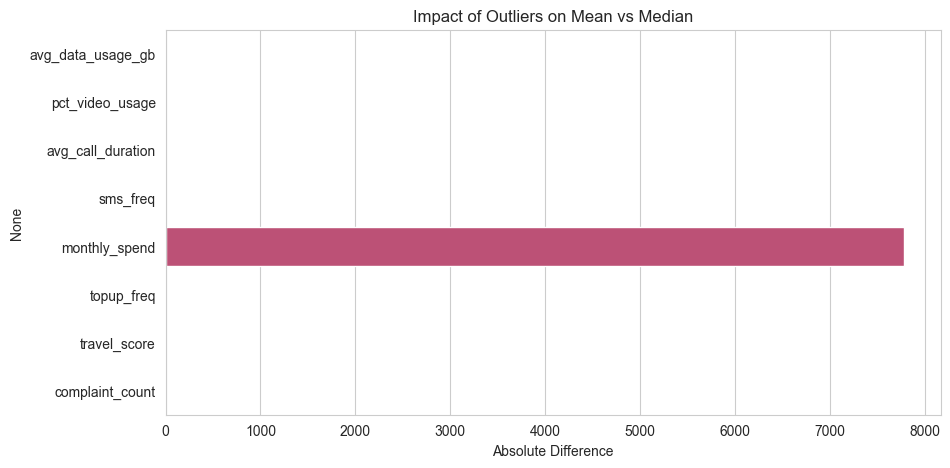

,mean,median,diff
avg_data_usage_gb,5.958883,4.990000,0.968883
pct_video_usage,0.402639,0.400116,0.002523
avg_call_duration,9.971357,10.020000,0.048643
sms_freq,15.010800,15.000000,0.010800
monthly_spend,109776.500000,102000.000000,7776.500000
topup_freq,2.986600,3.000000,0.013400
travel_score,0.282441,0.261206,0.021235
complaint_count,0.492600,0.000000,0.492600


In [58]:
impact_df = pd.DataFrame({
    "mean": df[num_cols].mean(),
    "median": df[num_cols].median()
})
impact_df["diff"] = (impact_df["mean"] - impact_df["median"]).abs()

plt.figure(figsize=(10, 5))
sns.barplot(x=impact_df["diff"], y=impact_df.index, palette="magma")
plt.title("Impact of Outliers on Mean vs Median")
plt.xlabel("Absolute Difference")
plt.show()

impact_df

## 19. Cramér's V untuk Korelasi Antar Fitur Kategorikal

C:\Users\Asus\AppData\Local\Temp\ipykernel_11852\2182857564.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_11852\2182857564.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_11852\2182857564.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_11852\2182857564.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_11852\2182857564.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))
C:\Users\Asus\AppData\Local\Temp\ipykernel_11852\2182857564.

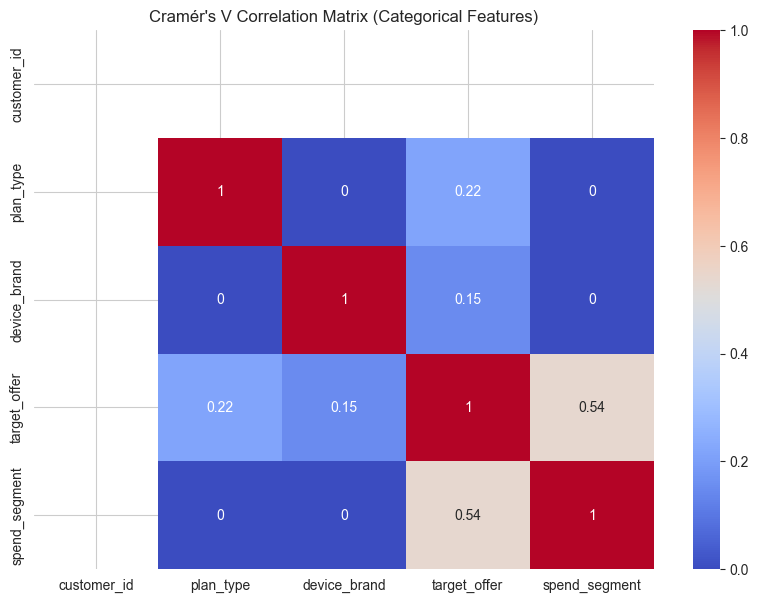

In [59]:
def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    phi2 = chi2 / n
    r, k = confusion.shape
    phi2_corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))
    r_corr = r - ((r - 1)**2)/(n - 1)
    k_corr = k - ((k - 1)**2)/(n - 1)
    return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

cramer_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        try:
            cramer_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])
        except:
            cramer_matrix.loc[col1, col2] = np.nan

plt.figure(figsize=(10, 7))
sns.heatmap(cramer_matrix.astype(float), annot=True, cmap='coolwarm')
plt.title("Cramér's V Correlation Matrix (Categorical Features)")
plt.show()

## 20. Target Leakage Check (Feature-Target Dependency)

In [60]:
df_leak = df.copy()
cat_features = df_leak.select_dtypes(include=['object', 'category']).columns.tolist()

# Encode kategorikal
encoder = OrdinalEncoder()
df_leak[cat_features] = encoder.fit_transform(df_leak[cat_features].astype(str))

X = df_leak.drop(columns=['target_offer', 'customer_id'])
y = df_leak['target_offer']

tree = DecisionTreeClassifier(random_state=42, max_depth=4)
tree.fit(X, y)

feature_importance = pd.Series(tree.feature_importances_, index=X.columns)
leakage_score = feature_importance.sort_values(ascending=False)

print("\n=== Possible Target Leakage Features ===")
print(leakage_score.head(10))


=== Possible Target Leakage Features ===
monthly_spend        0.325661
complaint_count      0.198925
pct_video_usage      0.175714
device_brand         0.160315
avg_data_usage_gb    0.092046
topup_freq           0.041175
travel_score         0.006163
plan_type            0.000000
avg_call_duration    0.000000
sms_freq             0.000000
dtype: float64


## 21. Hierarchical Clustering (Feature Redundancy)

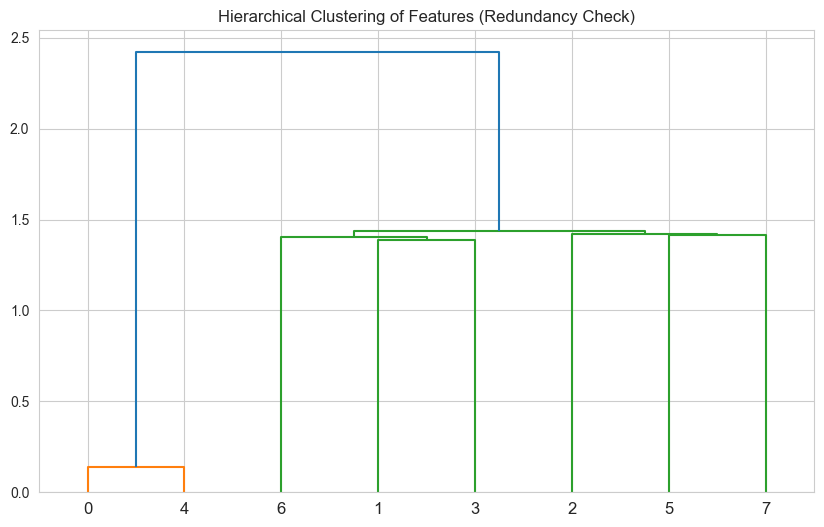

In [61]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
corr = df[numeric_cols].corr()

plt.figure(figsize=(10, 6))
dendrogram(linkage(corr, method='ward'))
plt.title("Hierarchical Clustering of Features (Redundancy Check)")
plt.show()

## 22. Class Imbalance Advanced Metrics

In [62]:
target_counts = df['target_offer'].value_counts()
target_entropy = entropy(target_counts)

ratio_majority_minority = target_counts.max() / target_counts.min()

print("\n=== Target Offer Balance Metrics ===")
print(f"Most common class: {target_counts.idxmax()}")
print(f"Least common class: {target_counts.idxmin()}")
print(f"Imbalance Ratio (Max/Min): {ratio_majority_minority:.2f}")
print(f"Shannon Entropy (Higher = more balanced): {target_entropy:.3f}")


=== Target Offer Balance Metrics ===
Most common class: General Offer
Least common class: Voice Bundle
Imbalance Ratio (Max/Min): 89.26
Shannon Entropy (Higher = more balanced): 1.318


## 23. Tukey HSD Post-Hoc Test (ANOVA Pairwise)

In [63]:
tukey_data = df[['monthly_spend', 'target_offer']].dropna()

tukey = pairwise_tukeyhsd(
    tukey_data['monthly_spend'],
    tukey_data['target_offer'],
    alpha=0.05
)

print("\n=== Tukey HSD Pairwise Test (Monthly Spend Across Target Offer) ===")
print(tukey)


=== Tukey HSD Pairwise Test (Monthly Spend Across Target Offer) ===
                       Multiple Comparison of Means - Tukey HSD, FWER=0.05                        
        group1                 group2           meandiff   p-adj     lower        upper     reject
--------------------------------------------------------------------------------------------------
          Data Booster   Device Upgrade Offer   -9598.7876    0.0  -14446.3168   -4751.2583   True
          Data Booster      Family Plan Offer  -38938.1787    0.0  -51838.2071  -26038.1503   True
          Data Booster          General Offer  -68285.4522    0.0  -72452.9473  -64117.9572   True
          Data Booster        Retention Offer  -81684.1919    0.0  -87290.5046  -76077.8792   True
          Data Booster           Roaming Pass  -60341.6036    0.0  -72462.6314  -48220.5758   True
          Data Booster Streaming Partner Pack  -60469.7606    0.0  -68392.9912  -52546.5301   True
          Data Booster           Top-up 

## 24. UMAP Visualization (Nonlinear Dimensionality Reduction)


c:\Users\Asus\Documents\ASAH 2025\CAPSTONE\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


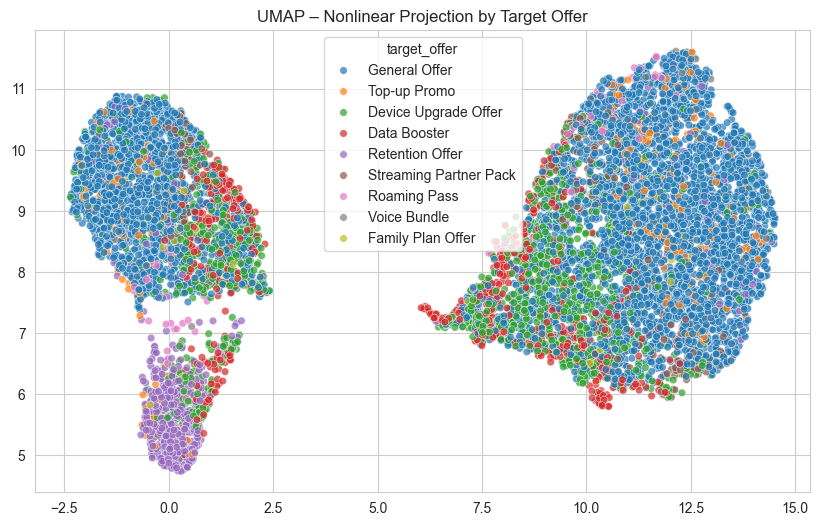

In [64]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols = [c for c in num_cols if c not in ['customer_id']]

scaled = StandardScaler().fit_transform(df[num_cols])
umap_2d = umap.UMAP(n_neighbors=20, min_dist=0.1, random_state=42).fit_transform(scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_2d[:,0], y=umap_2d[:,1], hue=df['target_offer'], s=30, alpha=0.7)
plt.title("UMAP – Nonlinear Projection by Target Offer")
plt.show()

## 25. Radar Chart for Customer Profile Segments

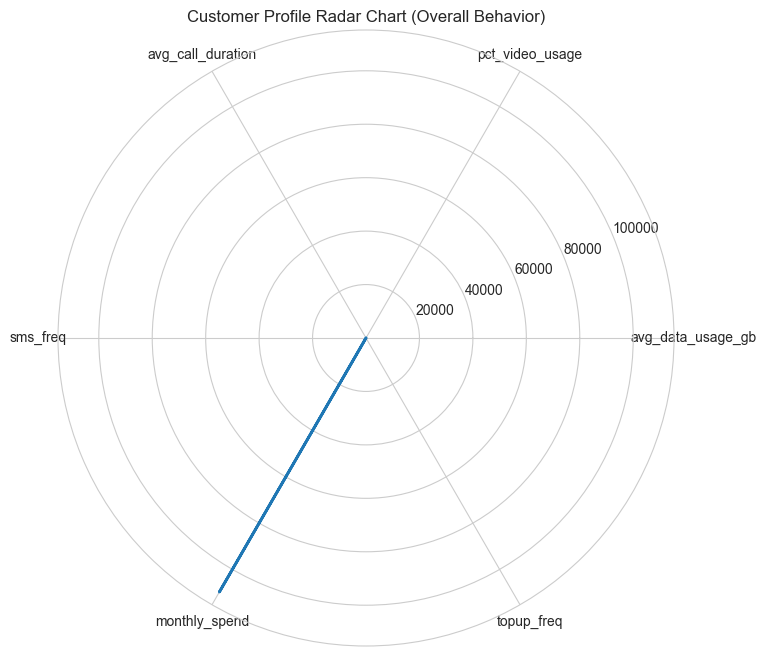

In [65]:
segment_features = ['avg_data_usage_gb','pct_video_usage','avg_call_duration','sms_freq','monthly_spend','topup_freq']
cluster_summary = df[segment_features].mean()

labels = list(cluster_summary.index)
stats = cluster_summary.values.tolist()
stats += stats[:1]

angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
angles += angles[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

plt.xticks(angles[:-1], labels)
ax.plot(angles, stats, linewidth=2, linestyle='solid')
ax.fill(angles, stats, alpha=0.4)
plt.title("Customer Profile Radar Chart (Overall Behavior)")
plt.show()


## 26. Kruskal-Wallis Test – Hubungan Fitur Numerik vs Target Offer (Alternatif Nonparametric ANOVA)

In [66]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['customer_id']]

print("\n=== Kruskal-Wallis Test untuk Numeric vs target_offer ===")
kruskal_results = {}

for col in numeric_cols:
    groups = [g[col].dropna() for name, g in df.groupby('target_offer')]
    stat, p = kruskal(*groups)
    kruskal_results[col] = p

kruskal_df = pd.DataFrame.from_dict(kruskal_results, orient='index', columns=['p_value'])
print(kruskal_df.sort_values("p_value").head(10))



=== Kruskal-Wallis Test untuk Numeric vs target_offer ===
                        p_value
avg_data_usage_gb  0.000000e+00
pct_video_usage    0.000000e+00
monthly_spend      0.000000e+00
complaint_count    0.000000e+00
travel_score       2.772621e-56
topup_freq         4.231451e-50
sms_freq           9.122088e-43
avg_call_duration  1.646163e-39


## 27. Interaction Heatmap Antar Fitur (Correlation antar Pairwise Product of Features)

In [67]:
interaction_features = {}

for f1, f2 in itertools.combinations(numeric_cols, 2):
    inter_col = f"{f1}*{f2}"
    interaction_features[inter_col] = df[f1] * df[f2]

interaction_df = pd.DataFrame(interaction_features)

# Korelasi dengan monthly_spend
interaction_corr = interaction_df.corrwith(df['monthly_spend']).sort_values(key=lambda x: abs(x), ascending=False)

print("\n=== Top Interaction Features yang terkait dengan monthly_spend ===")
print(interaction_corr.head(10))



=== Top Interaction Features yang terkait dengan monthly_spend ===
avg_data_usage_gb*monthly_spend        0.904579
sms_freq*monthly_spend                 0.833650
avg_data_usage_gb*sms_freq             0.824060
avg_data_usage_gb*avg_call_duration    0.692979
avg_data_usage_gb*pct_video_usage      0.685477
avg_data_usage_gb*travel_score         0.648631
avg_data_usage_gb*topup_freq           0.641952
avg_call_duration*monthly_spend        0.629002
pct_video_usage*monthly_spend          0.624018
monthly_spend*travel_score             0.574666
dtype: float64


## 28. Weighted Histograms untuk Bandingkan Distribusi per Plan Type

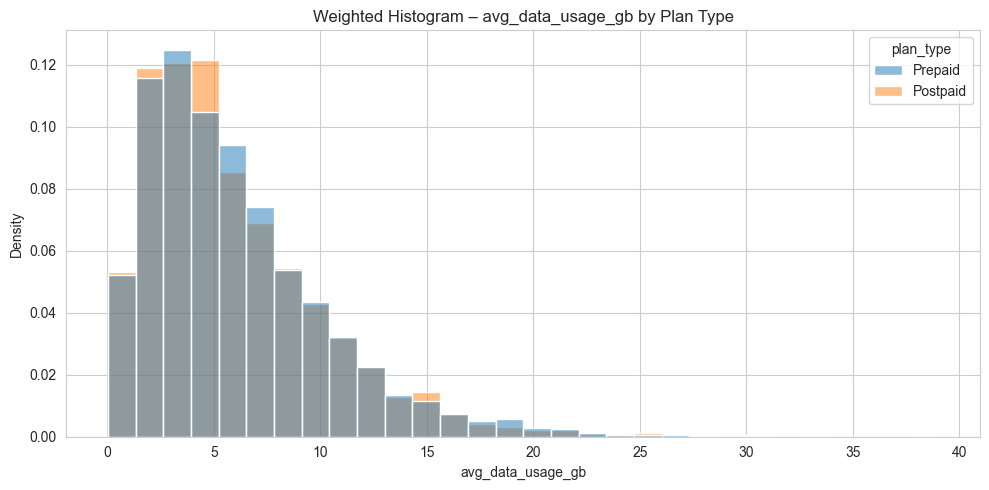

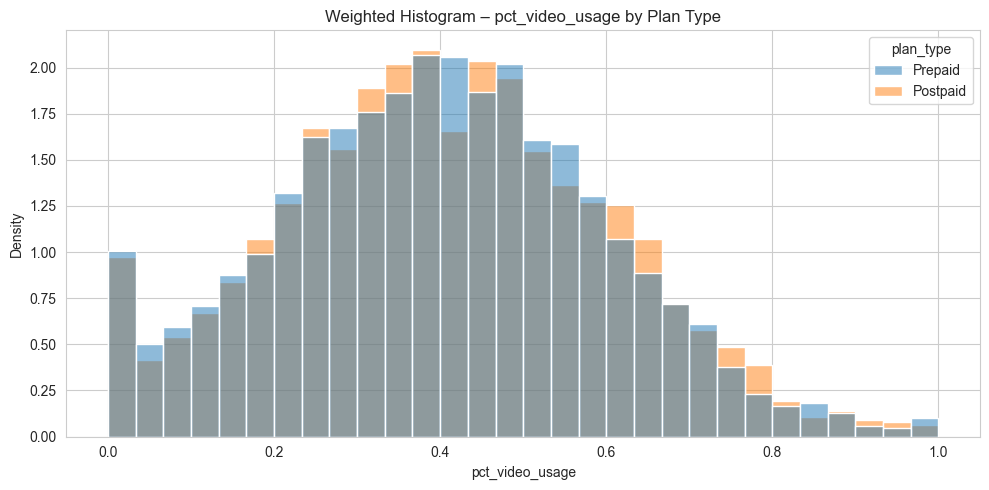

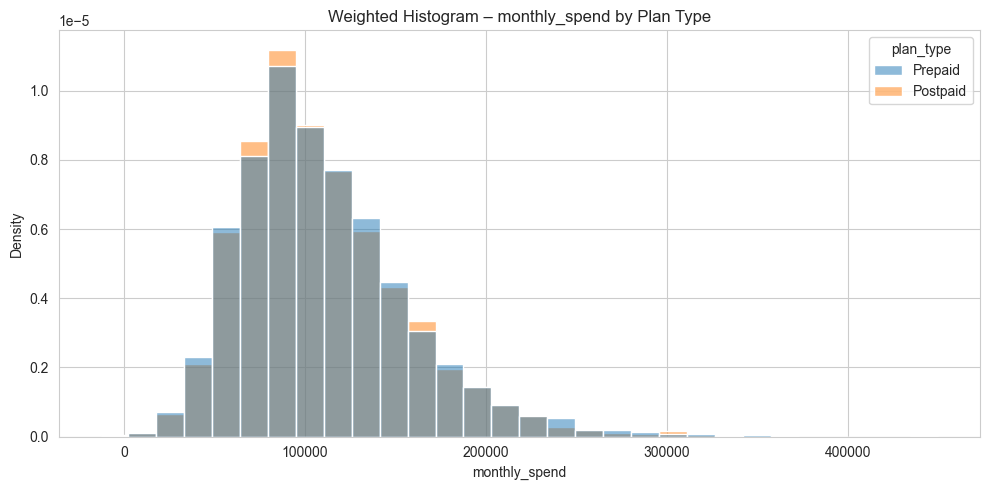

In [68]:
features_to_plot = ['avg_data_usage_gb', 'pct_video_usage', 'monthly_spend']

for col in features_to_plot:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df, x=col, hue='plan_type', stat='density', common_norm=False, bins=30)
    plt.title(f"Weighted Histogram – {col} by Plan Type")
    plt.tight_layout()
    plt.show()


## 29. Lift Analysis – Probabilitas Target per Segmentasi Spend

C:\Users\Asus\AppData\Local\Temp\ipykernel_11852\1331728233.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lift = df.groupby('spend_segment')['target_offer'].value_counts(normalize=True).unstack().fillna(0)


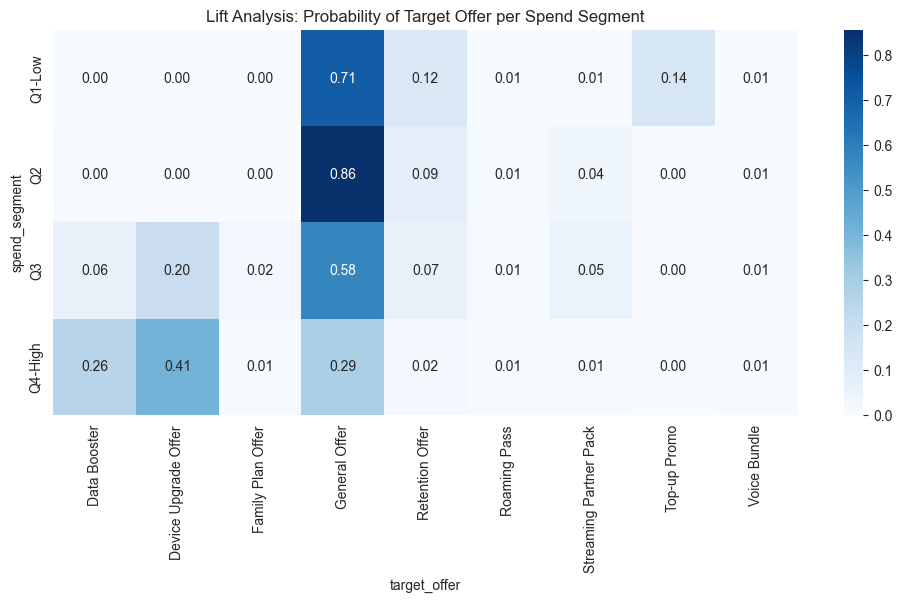


=== Lift Table ===
target_offer   Data Booster  Device Upgrade Offer  Family Plan Offer  \
spend_segment                                                          
Q1-Low             0.000771              0.000000           0.000000   
Q2                 0.004517              0.000000           0.002053   
Q3                 0.061184              0.198252           0.023441   
Q4-High            0.256724              0.408720           0.006927   

target_offer   General Offer  Retention Offer  Roaming Pass  \
spend_segment                                                 
Q1-Low              0.706631         0.124904      0.008867   
Q2                  0.855852         0.085421      0.009446   
Q3                  0.576480         0.068335      0.011919   
Q4-High             0.286064         0.023227      0.006927   

target_offer   Streaming Partner Pack  Top-up Promo  Voice Bundle  
spend_segment                                                      
Q1-Low                       0.0

In [69]:
df['spend_segment'] = pd.qcut(df['monthly_spend'], 4, labels=['Q1-Low','Q2','Q3','Q4-High'])

lift = df.groupby('spend_segment')['target_offer'].value_counts(normalize=True).unstack().fillna(0)

plt.figure(figsize=(12, 5))
sns.heatmap(lift, annot=True, fmt=".2f", cmap='Blues')
plt.title("Lift Analysis: Probability of Target Offer per Spend Segment")
plt.show()

print("\n=== Lift Table ===")
print(lift)


## 30. Cohort Analysis – Device Brand vs Spending Quartile


C:\Users\Asus\AppData\Local\Temp\ipykernel_11852\3994204752.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort = df.groupby(['device_brand', 'spend_q']).size().unstack(fill_value=0)


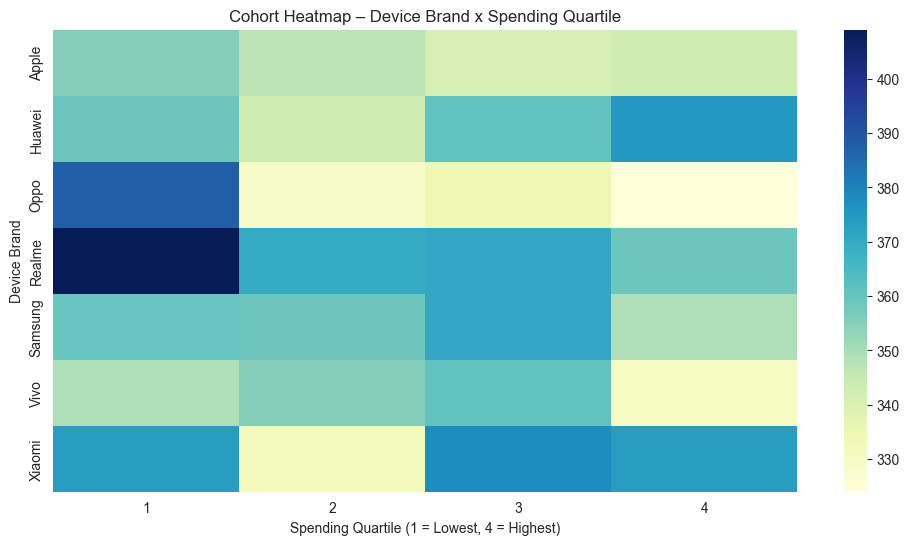


=== Cohort Table ===
spend_q         1    2    3    4
device_brand                    
Apple         355  347  341  343
Huawei        359  343  361  375
Oppo          388  329  334  324
Realme        409  370  371  359
Samsung       360  359  371  349


In [70]:
df['spend_q'] = pd.qcut(df['monthly_spend'], 4, labels=[1,2,3,4])

cohort = df.groupby(['device_brand', 'spend_q']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(cohort, cmap="YlGnBu", annot=False)
plt.title("Cohort Heatmap – Device Brand x Spending Quartile")
plt.ylabel("Device Brand")
plt.xlabel("Spending Quartile (1 = Lowest, 4 = Highest)")
plt.show()

print("\n=== Cohort Table ===")
print(cohort.head())
